# Showcasing the Correlated Field model

**Skip to `Parameter Showcases` for the meat/veggies ;)**

The field model roughly works like this:

`f = HT( A * zero_mode * xi ) + offset`

`A` is a spectral power field which is constructed from power spectra that hold on subdomains of the target domain.
It is scaled by a zero mode operator and then pointwise multiplied by a gaussian excitation field, yielding
a representation of the field in harmonic space.
It is then transformed into the target real space and a offset added.

The power spectra `A` is constructed of are in turn constructed as the sum of a power law component
and an integrated Wiener process whose amplitude and roughness can be set.

## Setup code

In [1]:
%matplotlib inline
import nifty8 as ift
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.style.use("seaborn-notebook")
import numpy as np

n_pix = 256
x_space = ift.RGSpace(n_pix)
ift.random.push_sseq_from_seed(1)

In [8]:
# Plotting routine
def plot(fields, spectra, title=None):
    # Plotting preparation is normally handled by nifty8.Plot
    # It is done manually here to be able to tweak details
    # Fields are assumed to have identical domains
    fig = plt.figure(tight_layout=True, figsize=(10, 3))
    if title is not None:
        fig.suptitle(title, fontsize=14)
    
    # Field
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.axhline(y=0., color='k', linestyle='--', alpha=0.25)
    for field in fields:
        dom = field.domain[0]
        xcoord = np.arange(dom.shape[0]) * dom.distances[0]
        ax1.plot(xcoord, field.val)
    ax1.set_xlim(xcoord[0], xcoord[-1])
    ax1.set_ylim(-5., 5.)
    ax1.set_xlabel('x')
    ax1.set_ylabel('f(x)')
    ax1.set_title('Field realizations')
    
    # Spectrum
    ax2 = fig.add_subplot(1, 2, 2)
    for spectrum in spectra:
        xcoord = spectrum.domain[0].k_lengths
        ycoord = spectrum.val_rw()
        ycoord[0] = ycoord[1]
        ax2.plot(xcoord, ycoord)
    ax2.set_ylim(1e-6, 10.)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('k')
    ax2.set_ylabel('p(k)')
    ax2.set_title('Power Spectrum')
    
    fig.align_labels()
    plt.show()

# Helper: draw main sample
main_sample = None
def init_model(m_pars, fl_pars, matern=False):
    global main_sample
    cf = ift.CorrelatedFieldMaker(m_pars["prefix"])
    cf.set_amplitude_total_offset(m_pars["offset_mean"], m_pars["offset_std"])
    cf.add_fluctuations_matern(**fl_pars) if matern else cf.add_fluctuations(**fl_pars)
    field = cf.finalize(prior_info=0)
    main_sample = ift.from_random(field.domain)
    print("model domain keys:", field.domain.keys())
    
# Helper: field and spectrum from parameter dictionaries + plotting
def eval_model(m_pars, fl_pars, title=None, samples=None, matern=False):
    cf = ift.CorrelatedFieldMaker(m_pars["prefix"])
    cf.set_amplitude_total_offset(m_pars["offset_mean"], m_pars["offset_std"])
    cf.add_fluctuations_matern(**fl_pars) if matern else cf.add_fluctuations(**fl_pars)
    field = cf.finalize(prior_info=0)
    spectrum = cf.amplitude
    if samples is None:
        samples = [main_sample]
    field_realizations = [field(s) for s in samples]
    spectrum_realizations = [spectrum.force(s) for s in samples]
    plot(field_realizations, spectrum_realizations, title)

def gen_samples(key_to_vary):
    if key_to_vary is None:
        return [main_sample]
    dct = main_sample.to_dict()
    subdom_to_vary = dct.pop(key_to_vary).domain
    samples = []
    for i in range(8):
        d = dct.copy()
        d[key_to_vary] = ift.from_random(subdom_to_vary)
        samples.append(ift.MultiField.from_dict(d))
    return samples
        
def vary_parameter(parameter_key, values, samples_vary_in=None, matern=False):
    s = gen_samples(samples_vary_in)
    for v in values:
        if parameter_key in cf_make_pars.keys():
            m_pars = {**cf_make_pars, parameter_key: v}
            eval_model(m_pars, cf_x_fluct_pars, f"{parameter_key} = {v}", s, matern)
        else:
            fl_pars = {**cf_x_fluct_pars, parameter_key: v}
            eval_model(cf_make_pars, fl_pars, f"{parameter_key} = {v}", s, matern)

## Before the Action: The Moment-Matched Log-Normal Distribution
Many properties of the correlated field are modelled as being lognormally distributed.

The distribution models are parametrized via their means and standard-deviations (first and second position in tuple).

To get a feeling of how the ratio of the `mean` and `stddev` parameters influences the distribution shape,
here are a few example histograms: (observe the x-axis!)

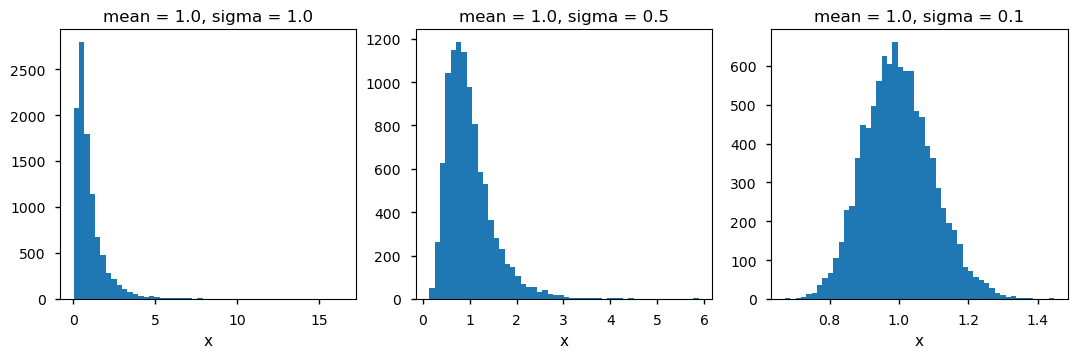

In [9]:
fig = plt.figure(figsize=(13, 3.5))
mean = 1.0
sigmas = [1.0, 0.5, 0.1]

for i in range(3):
    op = ift.LognormalTransform(mean=mean, sigma=sigmas[i],
                                key='foo', N_copies=0)
    op_samples = np.array(
        [op(s).val for s in [ift.from_random(op.domain) for i in range(10000)]])

    ax = fig.add_subplot(1, 3, i + 1)
    ax.hist(op_samples, bins=50)
    ax.set_title(f"mean = {mean}, sigma = {sigmas[i]}")
    ax.set_xlabel('x')
    del op_samples

plt.show()

## The Neutral Field

To demonstrate the effect of all parameters, first a 'neutral' set of parameters
is defined which then are varied one by one, showing the effect of the variation
on the generated field realizations and the underlying power spectrum from which
they were drawn.

As a neutral field, a model with a white power spectrum and vanishing spectral power was chosen.

In [10]:
# Neutral model parameters yielding a quasi-constant field
cf_make_pars = {
    'offset_mean': 0.,
    'offset_std': (1e-3, 1e-16),
    'prefix': ''
}

cf_x_fluct_pars = {
    'target_subdomain': x_space,
    'fluctuations': (1e-3, 1e-16),
    'flexibility': (1e-3, 1e-16),
    'asperity': (1e-3, 1e-16),
    'loglogavgslope': (0., 1e-16)
}

init_model(cf_make_pars, cf_x_fluct_pars)

model domain keys: ('asperity', 'flexibility', 'fluctuations', 'loglogavgslope', 'spectrum', 'xi', 'zeromode')


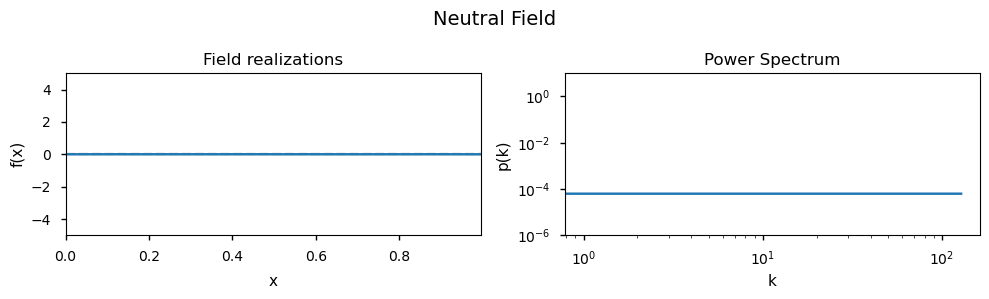

In [11]:
# Show neutral field
eval_model(cf_make_pars, cf_x_fluct_pars, "Neutral Field")

# Parameter Showcases

## The `fluctuations` parameters of `add_fluctuations()`

determine the **amplitude of variations along the field dimension**
for which `add_fluctuations` is called.

`fluctuations[0]` set the _average_ amplitude of the fields fluctuations along the given dimension,\
`fluctuations[1]` sets the width and shape of the amplitude distribution.

The amplitude is modelled as being log-normally distributed,
see `The Moment-Matched Log-Normal Distribution` above for details.

#### `fluctuations` mean:

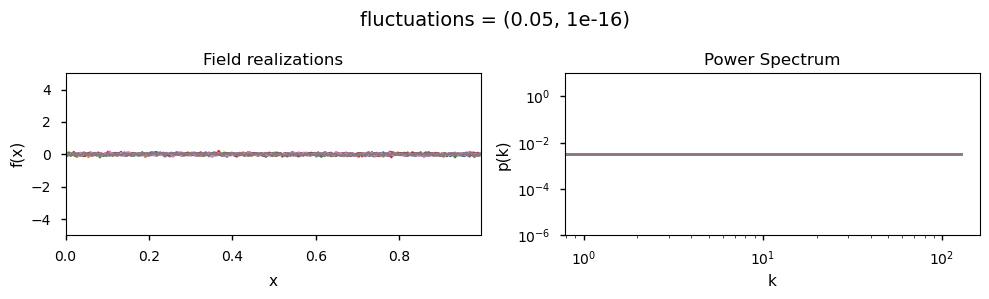

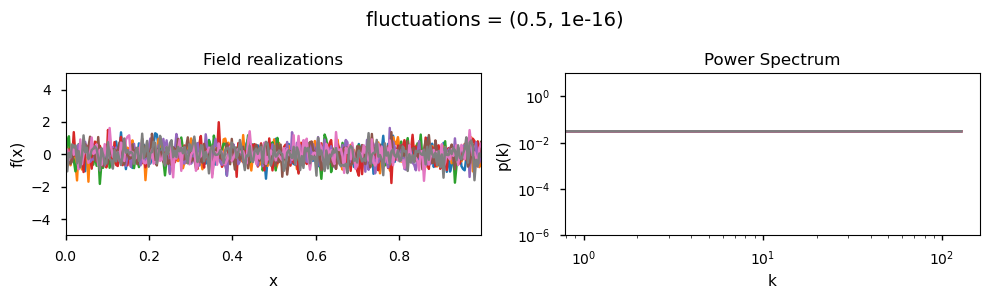

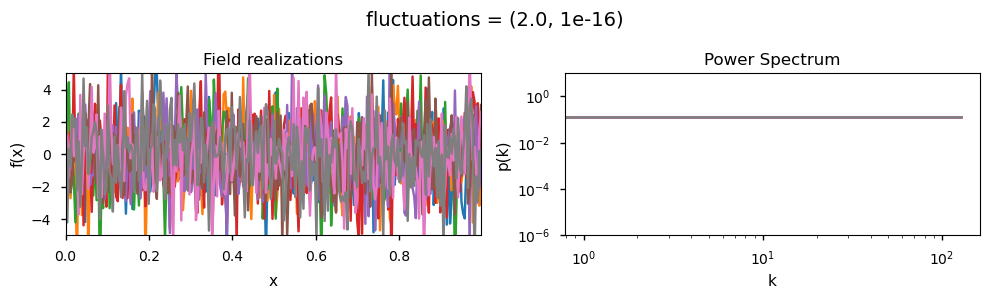

In [12]:
vary_parameter('fluctuations', [(0.05, 1e-16), (0.5, 1e-16), (2., 1e-16)], samples_vary_in='xi')

#### `fluctuations` std:

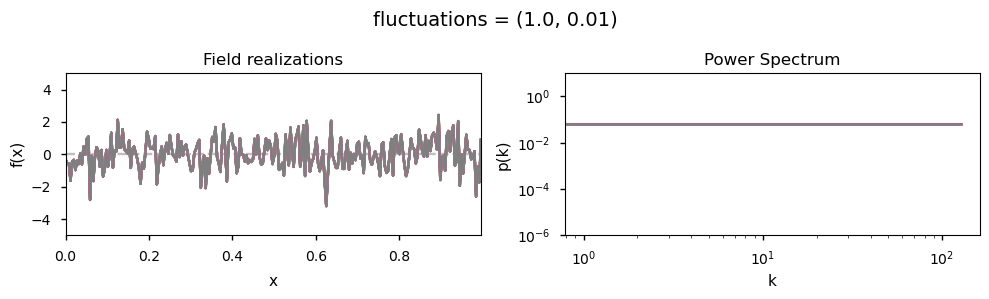

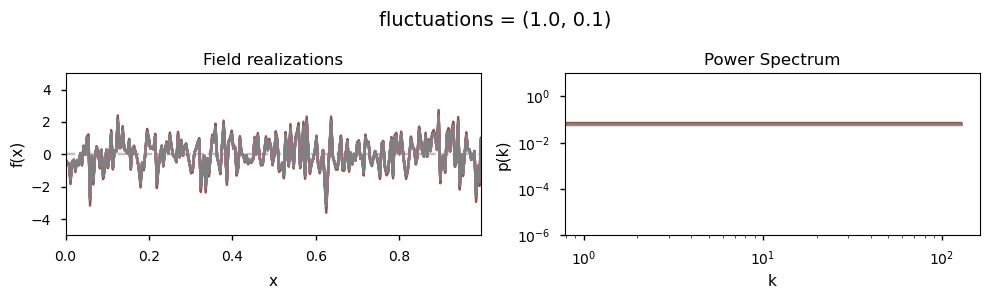

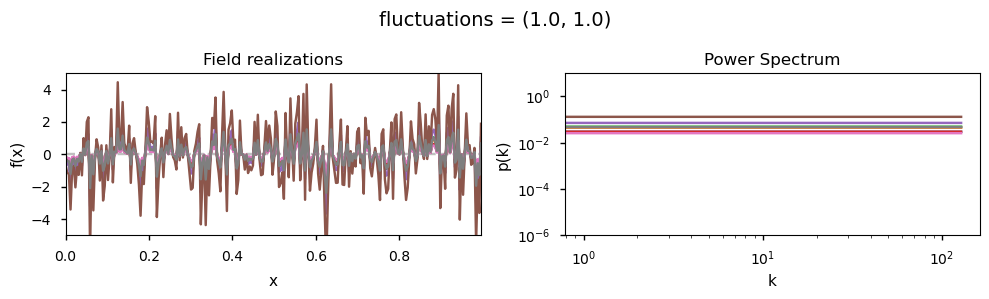

In [13]:
vary_parameter('fluctuations', [(1., 0.01), (1., 0.1), (1., 1.)], samples_vary_in='fluctuations')
cf_x_fluct_pars['fluctuations'] = (1., 1e-16)

## The `loglogavgslope` parameters of `add_fluctuations()`

determine **the slope of the loglog-linear (power law) component of the power spectrum**.

The slope is modelled to be normally distributed.

#### `loglogavgslope` mean:

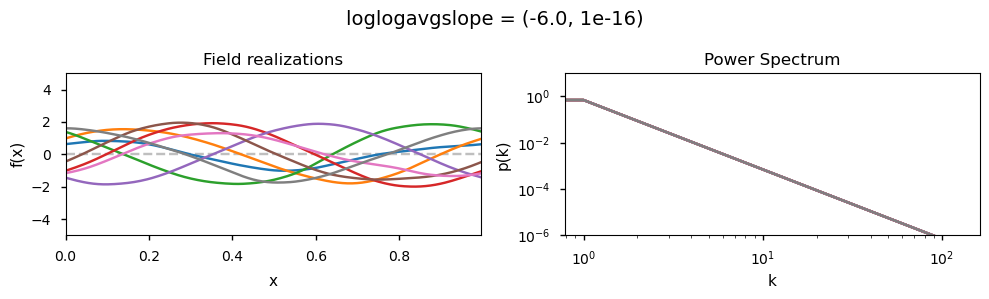

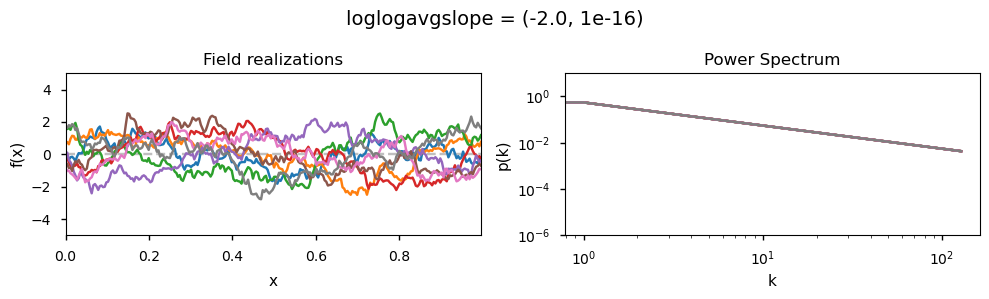

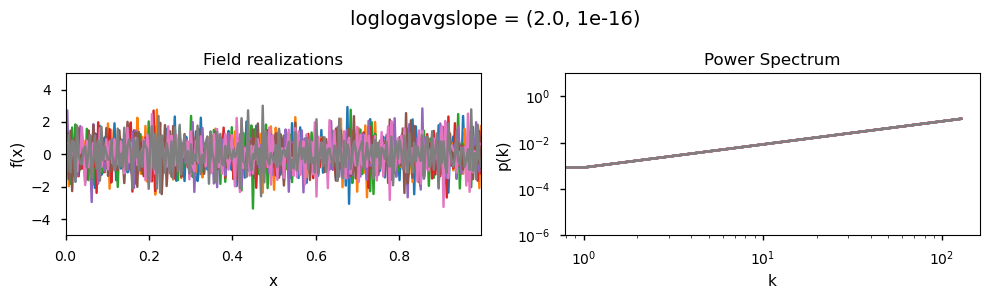

In [15]:
vary_parameter('loglogavgslope', [(-6., 1e-16), (-2., 1e-16), (2., 1e-16)], samples_vary_in='xi')

#### `loglogavgslope` std:

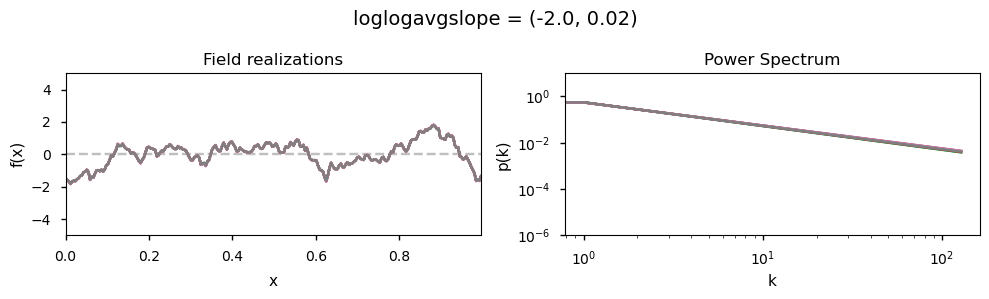

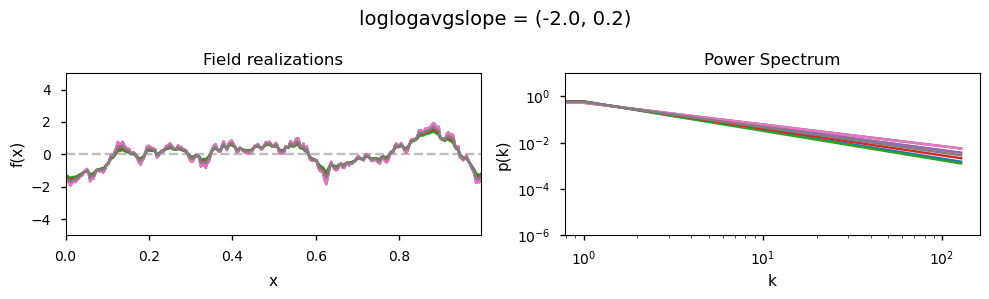

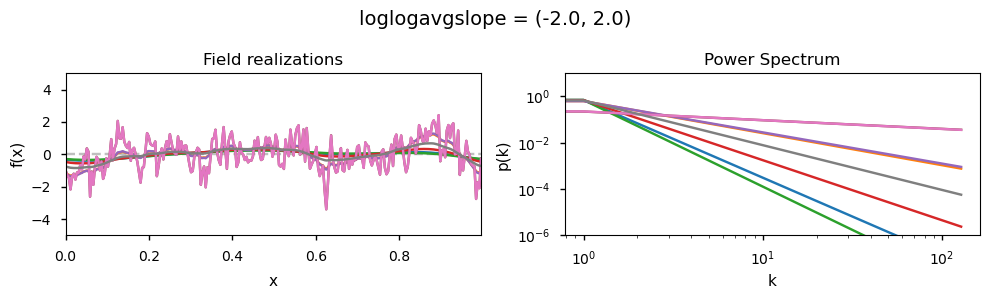

In [16]:
vary_parameter('loglogavgslope', [(-2., 0.02), (-2., 0.2), (-2., 2.0)], samples_vary_in='loglogavgslope')
cf_x_fluct_pars['loglogavgslope'] = (-2., 1e-16)

## The `flexibility` parameters of `add_fluctuations()`

determine **the amplitude of the integrated Wiener process component of the power spectrum**
(how strong the power spectrum varies besides the power-law).

`flexibility[0]` sets the _average_ amplitude of the i.g.p. component,\
`flexibility[1]` sets how much the amplitude can vary.\
These two parameters feed into a moment-matched log-normal distribution model,
see above for a demo of its behavior.

#### `flexibility` mean:

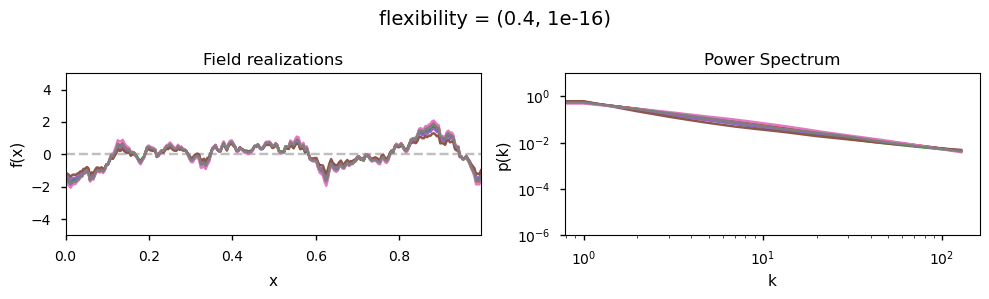

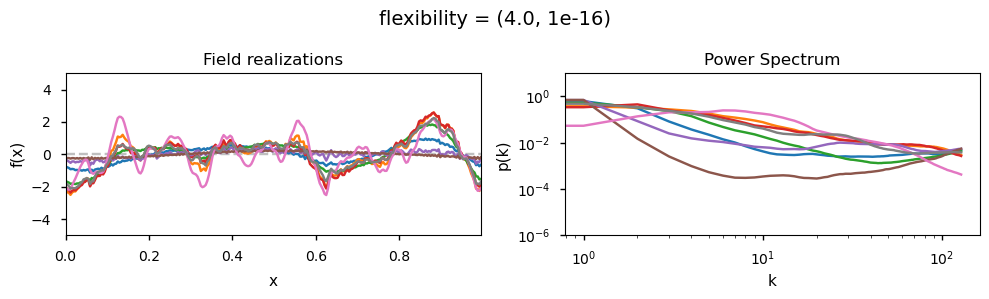

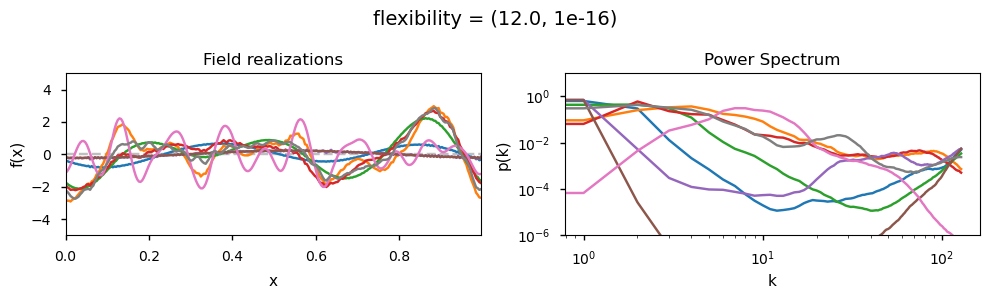

In [17]:
vary_parameter('flexibility', [(0.4, 1e-16), (4.0, 1e-16), (12.0, 1e-16)], samples_vary_in='spectrum')

#### `flexibility` std:

In [ ]:
vary_parameter('flexibility', [(4., 0.02), (4., 0.2), (4., 2.)], samples_vary_in='flexibility')
cf_x_fluct_pars['flexibility'] = (4., 1e-16)

## The `asperity` parameters of `add_fluctuations()`

`asperity` determines **how rough the integrated Wiener process component of the power spectrum is**.

`asperity[0]` sets the average roughness, `asperity[1]` sets how much the roughness can vary.\
These two parameters feed into a moment-matched log-normal distribution model,
see above for a demo of its behavior.

#### `asperity` mean:

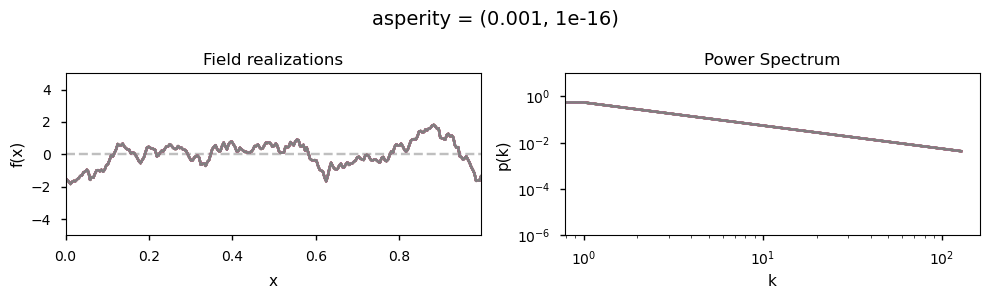

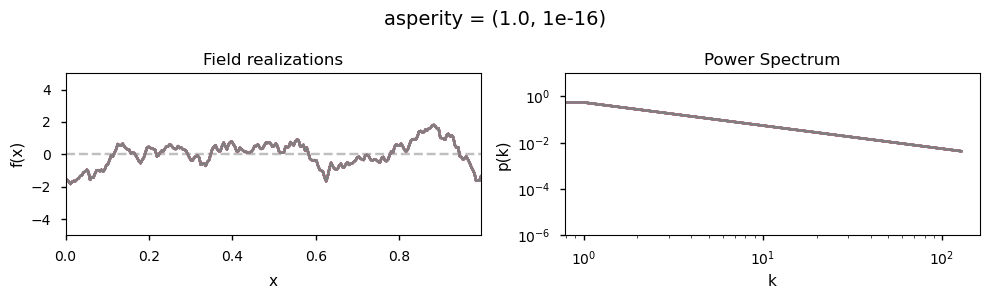

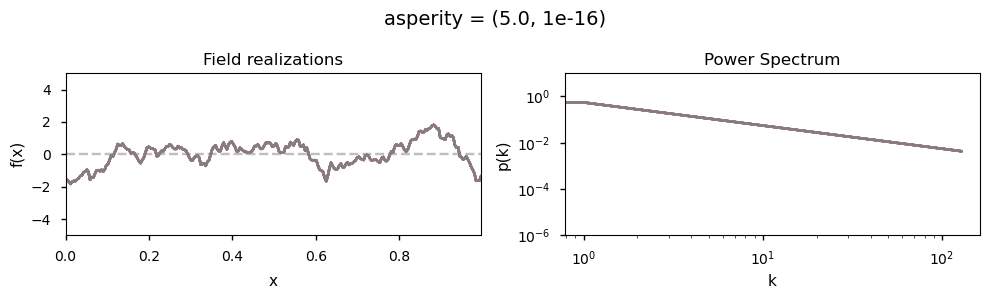

In [21]:
vary_parameter('asperity', [(0.001, 1e-16), (1.0, 1e-16), (5., 1e-16)], samples_vary_in='spectrum')

#### `asperity` std:

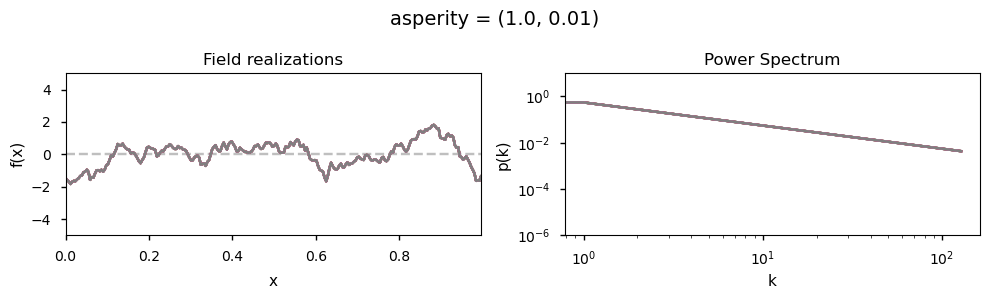

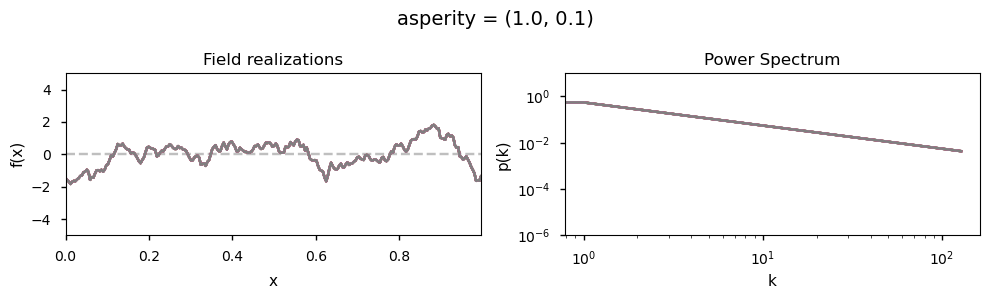

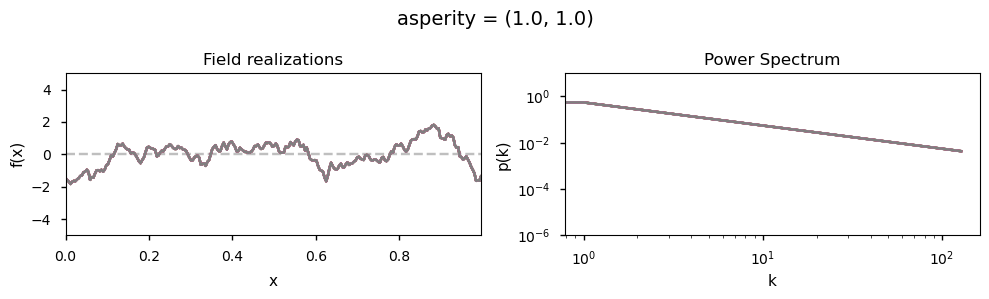

In [22]:
vary_parameter('asperity', [(1., 0.01), (1., 0.1), (1., 1.)], samples_vary_in='asperity')
cf_x_fluct_pars['asperity'] = (1., 1e-16)

## The `offset_mean` parameter of `CorrelatedFieldMaker()`

The `offset_mean` parameter defines a global additive offset on the field realizations.

If the field is used for a lognormal model `f = field.exp()`, this acts as a global signal magnitude offset.

In [23]:
# Reset model to neutral
cf_x_fluct_pars['fluctuations'] = (1e-3, 1e-16)
cf_x_fluct_pars['flexibility'] = (1e-3, 1e-16)
cf_x_fluct_pars['asperity'] = (1e-3, 1e-16)
cf_x_fluct_pars['loglogavgslope'] = (1e-3, 1e-16)

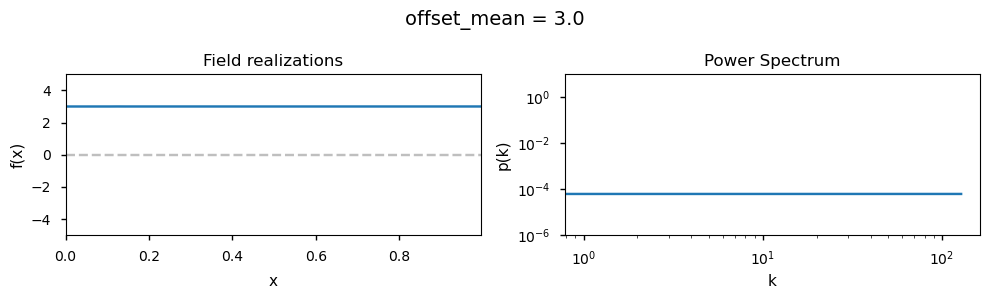

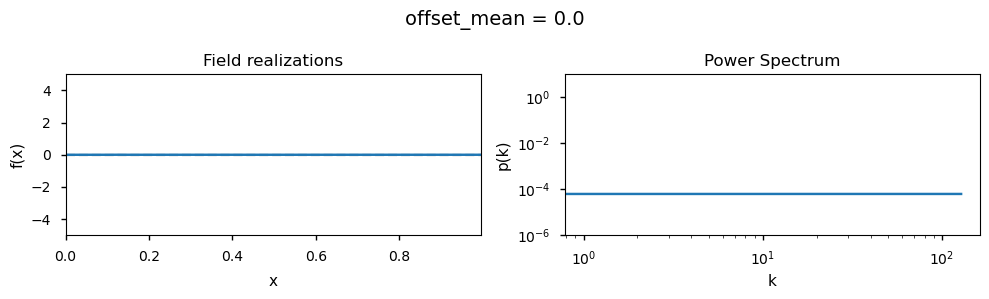

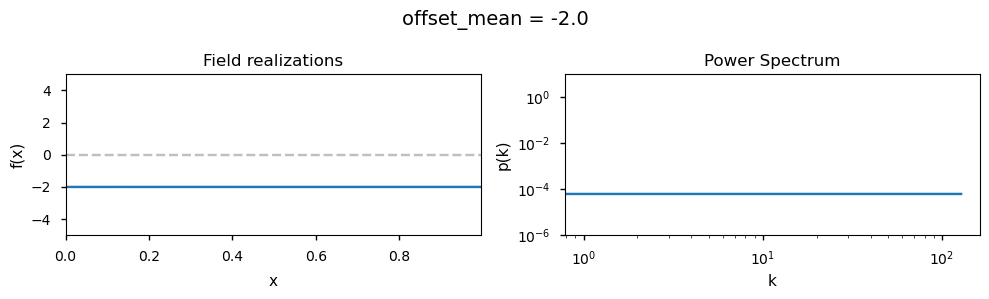

In [24]:
vary_parameter('offset_mean', [3., 0., -2.])

## The `offset_std` parameters of `CorrelatedFieldMaker()`

Variation of the global offset of the field are modelled as being log-normally distributed.
See `The Moment-Matched Log-Normal Distribution` above for details.

The `offset_std[0]` parameter sets how much NIFTy will vary the offset *on average*.\
The `offset_std[1]` parameters defines the with and shape of the offset variation distribution.

#### `offset_std` mean:

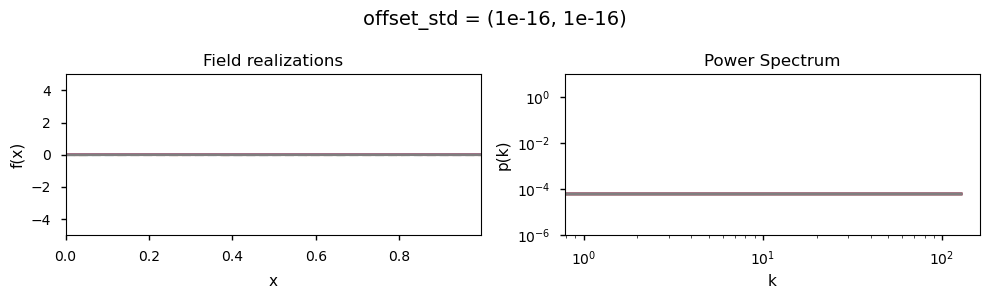

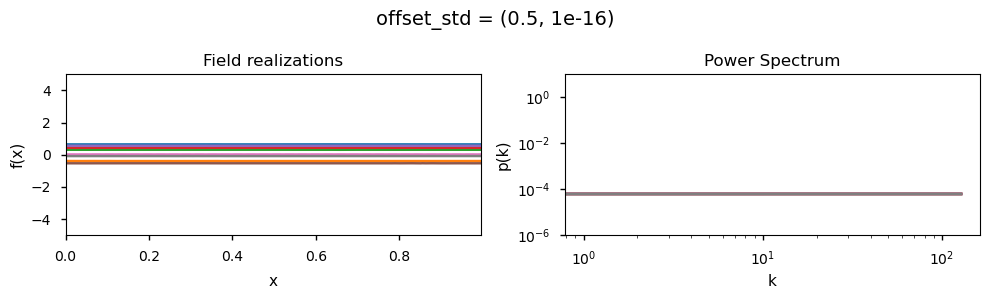

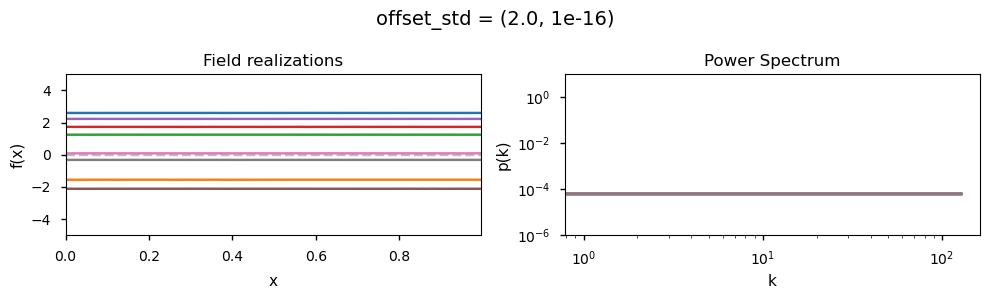

In [25]:
vary_parameter('offset_std', [(1e-16, 1e-16), (0.5, 1e-16), (2., 1e-16)], samples_vary_in='xi')

#### `offset_std` std:

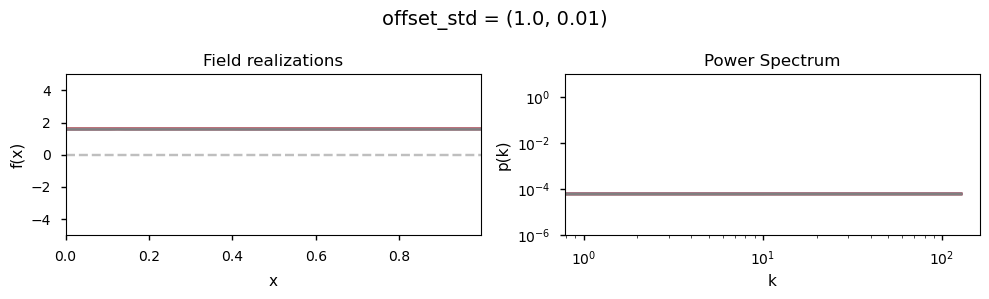

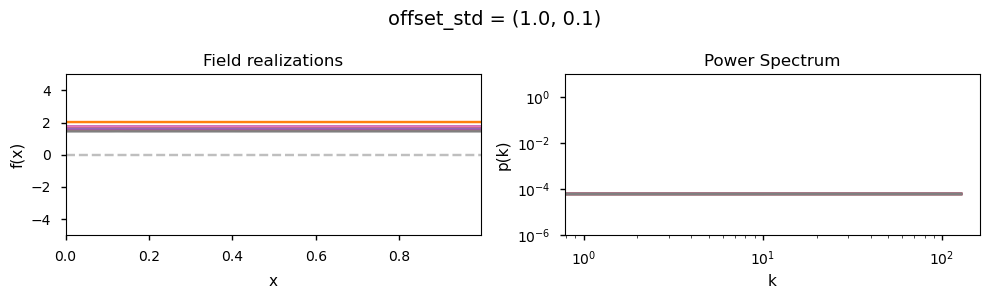

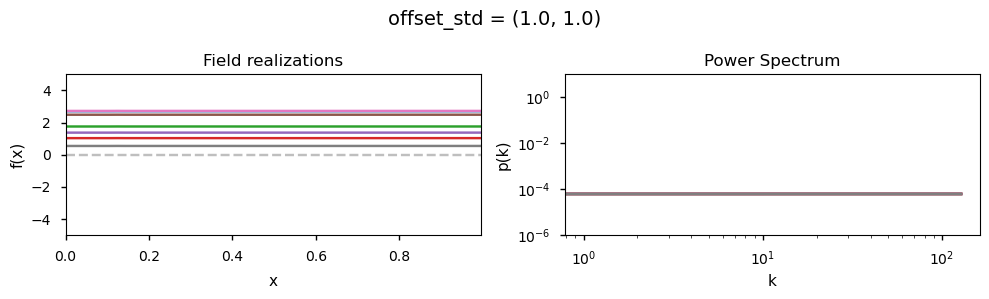

In [26]:
vary_parameter('offset_std', [(1., 0.01), (1., 0.1), (1., 1.)], samples_vary_in='zeromode')

## Matern fluctuation kernels

The correlated fields model also supports parametrizing the power spectra of field dimensions
using Matern kernels. In the following, the effects of their parameters are demonstrated.

Contrary to the field fluctuations parametrization showed above, the Matern kernel
parameters show strong interactions. For example, the field amplitude does not only depend on the
amplitude scaling parameter `scale`, but on the combination of all three parameters `scale`,
`cutoff` and `loglogslope`.

In [27]:
# Neutral model parameters yielding a quasi-constant field
cf_make_pars = {
    'offset_mean': 0.,
    'offset_std': (1e-3, 1e-16),
    'prefix': ''
}

In [28]:
cf_x_fluct_pars = {
    'target_subdomain': x_space,
    'scale': (1e-2, 1e-16),
    'cutoff': (1., 1e-16),
    'loglogslope': (-2.0, 1e-16)
}

In [29]:
init_model(cf_make_pars, cf_x_fluct_pars, matern=True)

model domain keys: ('cutoff', 'loglogslope', 'scale', 'xi', 'zeromode')


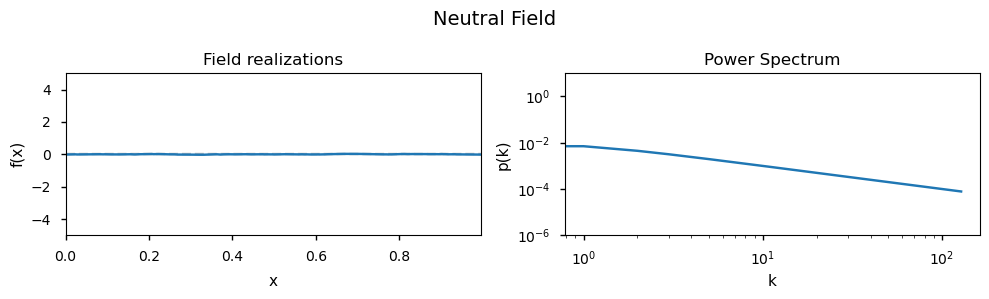

In [30]:
# Show neutral field
eval_model(cf_make_pars, cf_x_fluct_pars, "Neutral Field", matern=True)

# Parameter Showcases

## The `scale` parameters of `add_fluctuations_matern()`

determine the **overall amplitude scaling factor of fluctuations in the target subdomain**
for which `add_fluctuations_matern` is called.

**It does not set the absolute amplitude**, which depends on all other parameters, too.

`scale[0]` set the _average_ amplitude scaling factor of the fields' fluctuations along the given dimension,\
`scale[1]` sets the width and shape of the scaling factor distribution.

The scaling factor is modelled as being log-normally distributed,
see `The Moment-Matched Log-Normal Distribution` above for details.

#### `scale` mean:

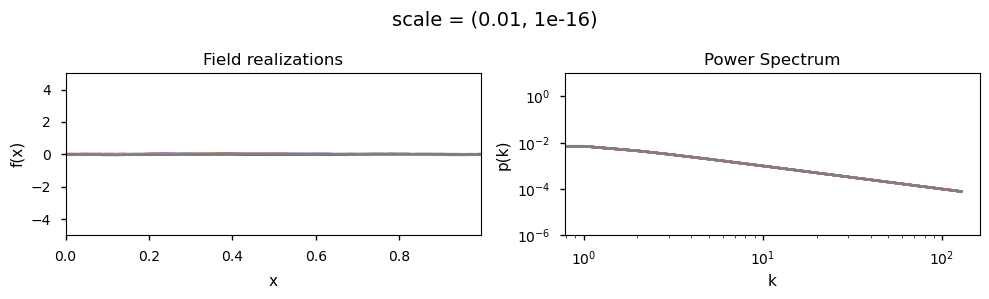

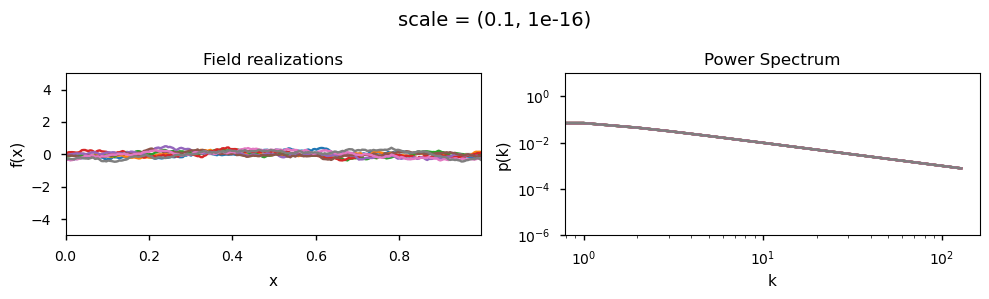

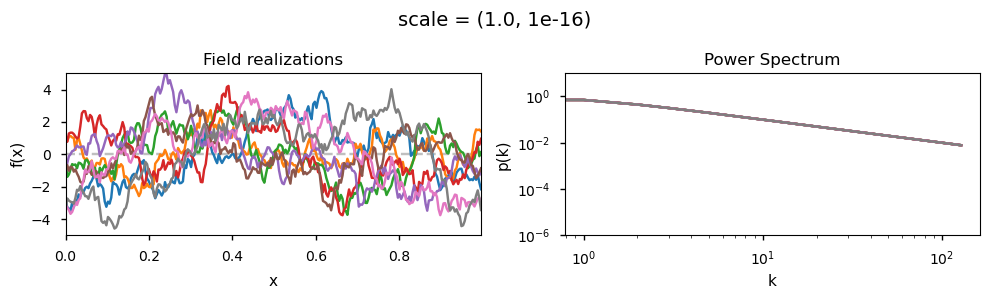

In [31]:
vary_parameter('scale', [(0.01, 1e-16), (0.1, 1e-16), (1.0, 1e-16)], samples_vary_in='xi', matern=True)

#### `scale` std:

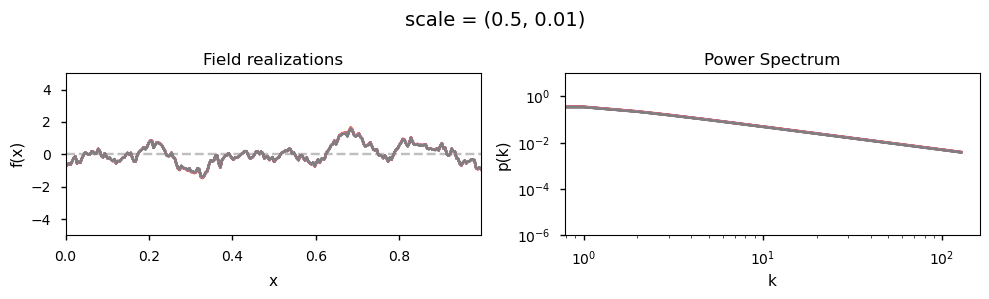

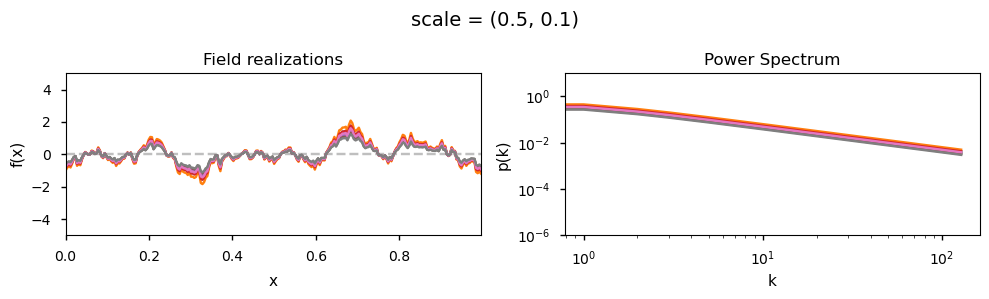

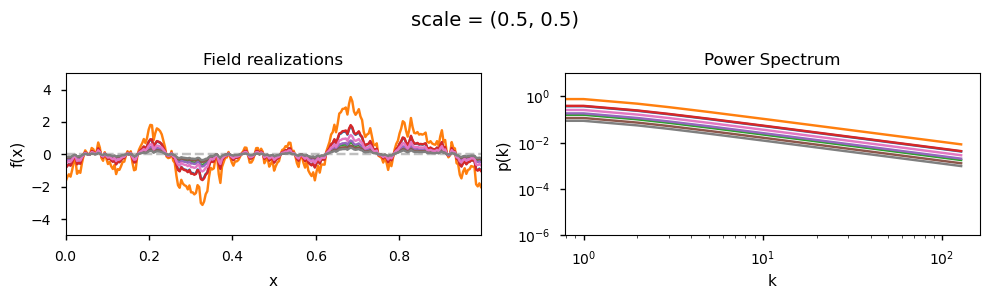

In [32]:
vary_parameter('scale', [(0.5, 0.01), (0.5, 0.1), (0.5, 0.5)], samples_vary_in='scale', matern=True)
cf_x_fluct_pars['scale'] = (0.5, 1e-16)

## The `loglogslope` parameters of `add_fluctuations_matern()`

determine **the slope of the loglog-linear (power law) component of the power spectrum**.

`loglogslope[0]` set the _average_ power law exponent of the fields' power spectrum along the given dimension,\
`loglogslope[1]` sets the width and shape of the exponent distribution.

The `loglogslope` is modelled to be normally distributed.

#### `loglogslope` mean:

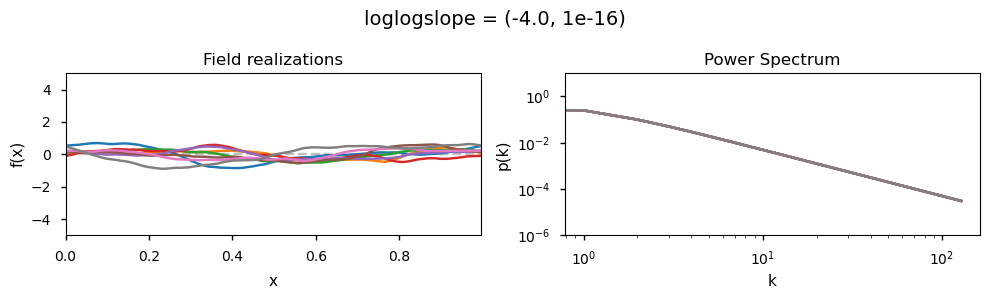

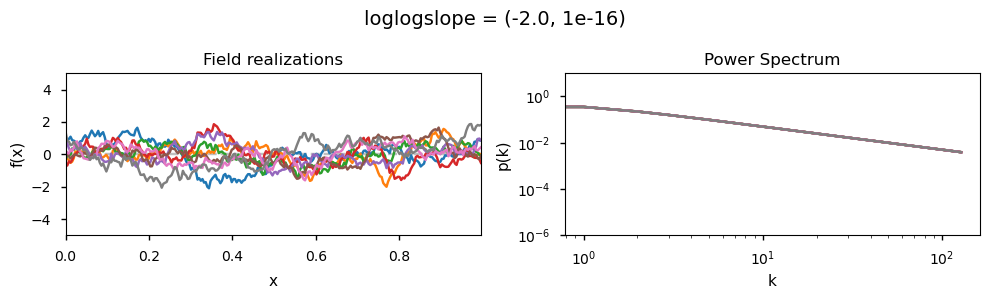

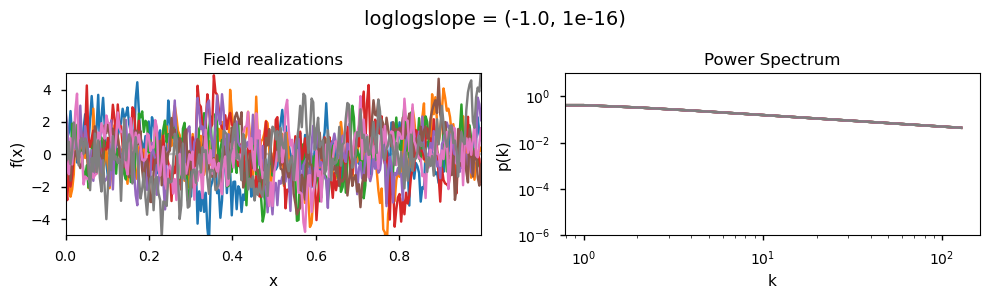

In [33]:
vary_parameter('loglogslope', [(-4.0, 1e-16), (-2.0, 1e-16), (-1.0, 1e-16)], samples_vary_in='xi', matern=True)

As one can see, the field amplitude also depends on the `loglogslope` parameter.

#### `loglogslope` std:

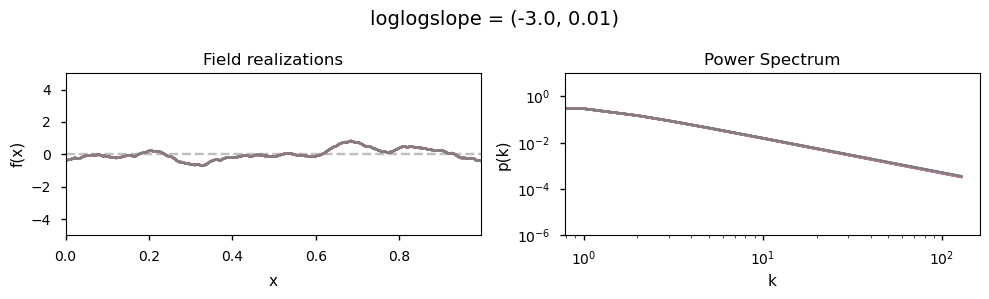

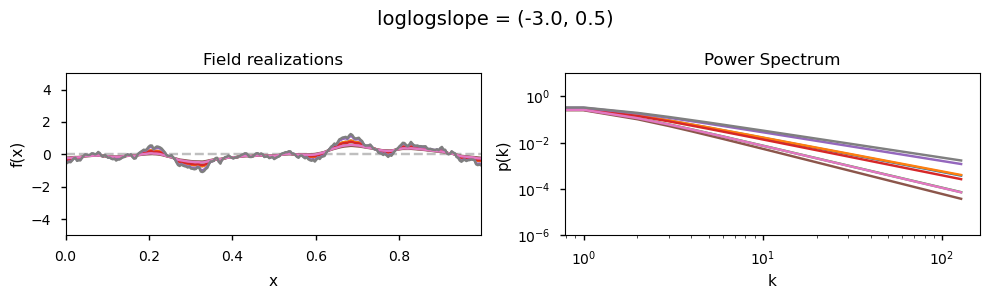

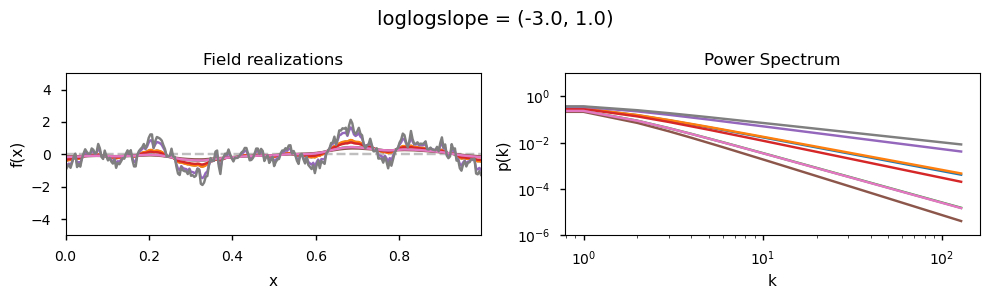

In [34]:
vary_parameter('loglogslope', [(-3., 0.01), (-3., 0.5), (-3., 1.0)], samples_vary_in='loglogslope', matern=True)

## The `cutoff` parameters of `add_fluctuations_matern()`

determines **at what wavevector length the power spectrum should transition from constant power
to following the powerlaw set by `loglogslope`**.

`cutoff[0]` set the _average_ wavevector length at which the power spectrum transition occurs,\
`cutoff[1]` sets the width and shape of the transition wavevector length distribution.

The cutoff is modelled as being log-normally distributed,
see `The Moment-Matched Log-Normal Distribution` above for details.

#### `cutoff` mean:

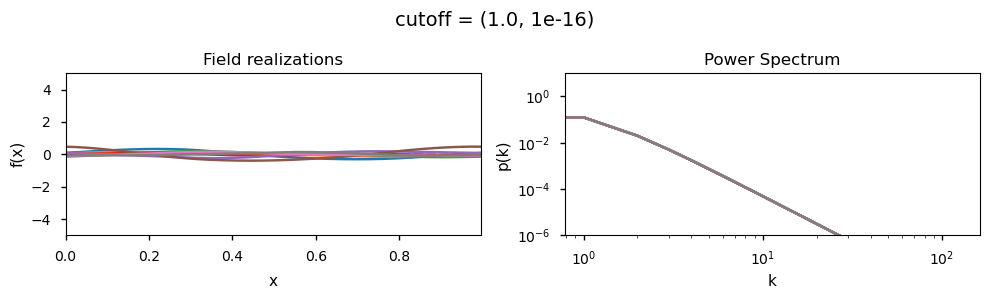

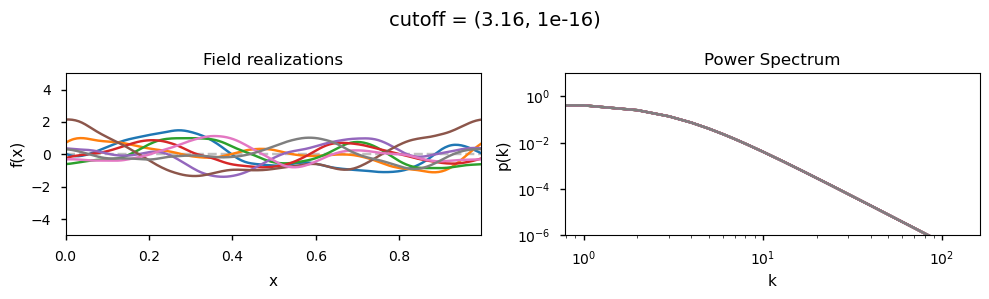

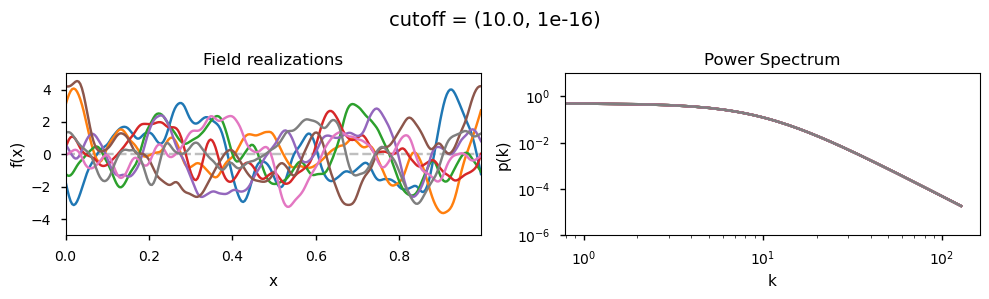

In [35]:
cf_x_fluct_pars['loglogslope'] = (-8.0, 1e-16)
vary_parameter('cutoff', [(1.0, 1e-16), (3.16, 1e-16), (10.0, 1e-16)], samples_vary_in='xi', matern=True)

#### `cutoff` std:

In [ ]:
vary_parameter('cutoff', [(10., 1.0), (10., 3.16), (10., 10.)], samples_vary_in='cutoff', matern=True)